PROJECT PROPOSAL: Predicting the Seeding of a Tennis Winner Through Data Analysis

PREDICTIVE QUESTION:

Given a winner’s number of aces (w_ace) and number of serve points (w_pvpt), predict what seed number (1-3) this player is, in a clay surface tournament.

INTRODUCTION:

The dataset we employed for this project included information for every ATP (Association of Tennis Professionals) match dating back to 1968.  However, for this project, we are focusing on data from the years 2017 to 2019. The central question of this project is to determine the seed number for players on clay surface tournaments based on two factors: the number of aces achieved by the winner (w_ace) and the number of serve points (w_pvpt).

A "seed" is an initial ranking in a tournament to ensure top players don't face each other early, An "ace" is an untouched serve by the receiver, winning a point for the server. "Serve points" are serves until the receiver fails to return. The "surface" is the court material (hard, grass, clay, or carpet), impacting playing style and match predictions.

PRELIMINARY DATA ANALYSIS:

In [93]:
# install packages
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [94]:
# load packages
library(tidyverse)
library(repr)
library(tidymodels)

In [97]:
# load data
url <- "https://raw.githubusercontent.com/Caseyxyq/Dsci100_group44/main/atp2017-2019.csv"
atp_data <- read_csv(url)
head(atp_data, n = 3)

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050


In [98]:
filtered_selected_columns <- atp_data |>
    # convert the character winner_seed variable to the numeric datatype so it can be filtered
    mutate(winner_seed = as.numeric(winner_seed)) |>
    filter(surface == "Clay", winner_seed <= 3.00) |> 
    select(w_ace, w_svpt, winner_seed)
head(filtered_selected_columns, n = 3)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `winner_seed = as.numeric(winner_seed)`.
Caused by warning:
! NAs introduced by coercion”


w_ace,w_svpt,winner_seed
<dbl>,<dbl>,<dbl>
3,94,3
4,40,3
4,52,3


In [99]:
final_atp_data <- filtered_selected_columns |>
    # Remove the NA values
    drop_na() |>
    # convert the character winner_seed variable to the factor datatype so it can be classified
    mutate(winner_seed = as_factor(winner_seed))
head(final_atp_data, n = 3)

w_ace,w_svpt,winner_seed
<dbl>,<dbl>,<fct>
3,94,3
4,40,3
4,52,3


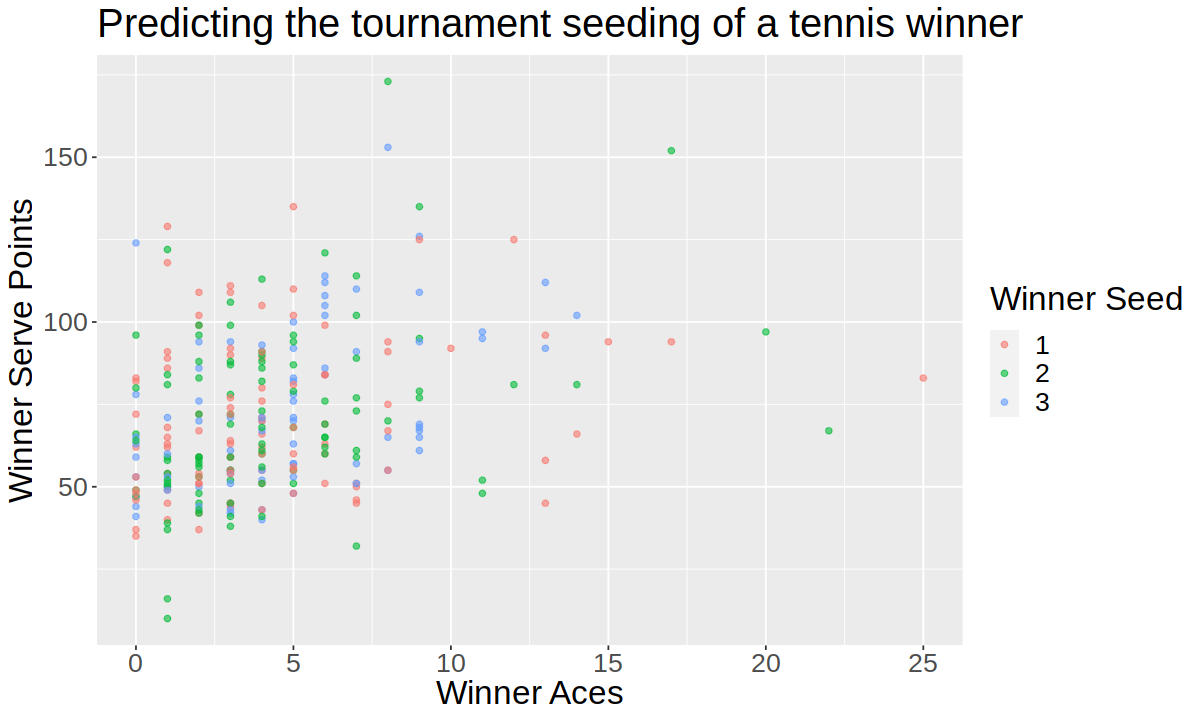

In [107]:
# create scatter plot of winner serve points versus winner aces,
# label the points with winner seed
atp_plot <- final_atp_data |>  
    ggplot(aes(x = w_ace, 
               y = w_svpt, 
               colour = winner_seed)) +
    geom_point(alpha = 0.6) +
    labs(x = "Winner Aces",
         y = "Winner Serve Points",
         colour = 'Winner Seed') +
    ggtitle("Predicting the tournament seeding of a tennis winner") +
    theme(text = element_text(size = 20))
options(repr.plot.width = 10, repr.plot.height = 6)
atp_plot

In [108]:
# set the seed
set.seed(3456) 

# create the 25/75 split of the training data into training and validation
atp_split <- initial_split(final_atp_data, prop = 0.75, strata = winner_seed)
atp_train <- training(atp_split)
atp_test <- testing(atp_split)

In [109]:
# standardize the recipe
atp_recipe <- recipe(winner_seed ~ w_ace + w_svpt, data = atp_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [110]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [111]:
# perform cross-validation
atp_vfold <- vfold_cv(atp_train, v = 5, strata = winner_seed)

In [112]:
# select parameter value
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

In [116]:
knn_results <- workflow() |>
  add_recipe(atp_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = atp_vfold, grid = k_vals) |>
  collect_metrics()

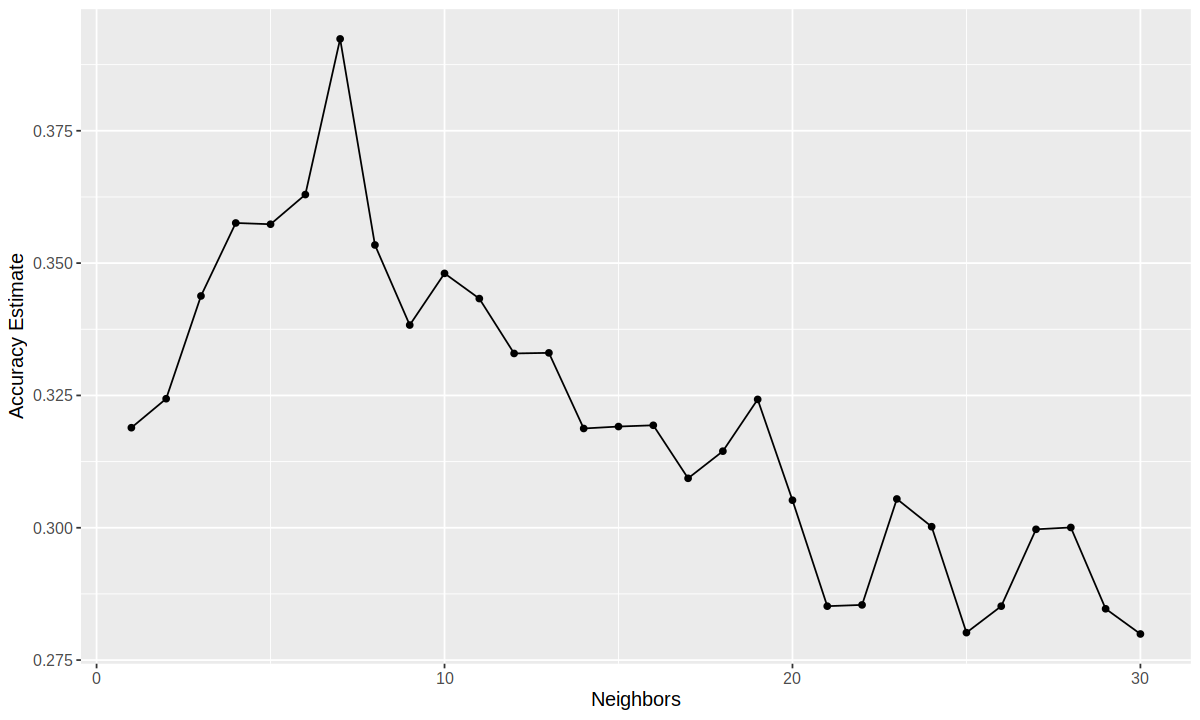

In [117]:
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

In [118]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

# fit the knn model
knn_fit <- workflow() |>
  add_recipe(atp_recipe) |>
  add_model(knn_spec) |>
  fit(data = atp_train)

In [119]:
# get predictions on the validation data
atp_test_predictions <- predict(knn_fit, atp_test) |>
  bind_cols(atp_test)

In [120]:
# compute the accuracy
atp_test_predictions |>
  metrics(truth = winner_seed, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3478261


In [121]:
confusion <- atp_test_predictions |>
             conf_mat(truth = winner_seed, estimate = .pred_class)
confusion

          Truth
Prediction  1  2  3
         1  8 10  7
         2  7  7  3
         3 10  8  9

Accuracy = (8+7+9)/(8+10+7+7+7+3+10+8+9) = 0.3478

METHODS:

We’ll predict seed number of a winner using two numerical variables: winner’s number of aces and winner's number of serve points.

Firstly, we read the dataset from a url so it can be seen without downloading locally. To clean and wrangle, we select columns that will be used in our prediction: surface, w_ace, w_pvpt and winner_seed. As we predict the top 3 seed numbers, we filter for seed numbers (=<3), filter clay as the type of surface, and remove all NA values. With our final dataset, we summarize values into useful tables. Next, we split the data into training set and test set so the classifier is built based on the training set and later used to predict data in the test set. Finally, we visualize the data by creating a scatter plot with winner’s number of aces and winner’s number of serve points on each axis, and different colored seed numbers for differentiation. Labels of axes, legend, and plot title are also added to make effective visualizations.

OUTCOMES AND SIGNIFICANCE:

With our analysis, we’ll have a clear visualization demonstrating the relationship between the seed number of a tennis player, aces achieved by the winner, and serve points received by the winner on clay ground. We can classify the “overall seed” of winners who obtain a certain number of aces and serve points. Our data can verify the accuracy of seeds (how accurately does seed reflect player skill) based on whether a higher seed obtains more aces and serve points. If it reflects that winner seed assignment is inaccurate, it could lead to innovation in seed prediction. Since higher seed players are better, we can also draw explanations to questions like: “ If better players (higher seed) generally get more aces/serve points.” Our set of data can also be compared to a similar set where data is filtered to a different surface, and that can be taken to see if surfaces affect the overall study of the example questions above. Overall, we hope the results will draw more insight for future questions regarding relationships between winner seed and winner statistics.